# CSCE 320 - Classifying Movie Genres based on its Movie Poster

# Overview, Project Goals and Motivation

Movie posters can be designed in a confusing way even for humans. We wanted to create a model that is able to predict the movie genre of a movie poster. The purpose of this project is to determine some features of a movie poster has that may be key factors in analyzing what genre the movie belongs to and whether a neural network is capable of doing a reasonable job predicting genres based on a single poster.

Our primary goal is to create a working prediction model to predict the genre of movie that a movie is based primarily on the poster only. Our secondary goal was to look at features of movie posters and see whether there are any patterns that emerge from them. The features that this study looked at was the dominant color of the movie poster and the number of faces on the poster.

From the neural network, we may eventually apply it to any screenshot from the movie and use that screenshot as promotional material for the movie to target specific audiences. However within the scope of this study, we will not be creating this application.

# Initial Questions
Does the dominant color of poster and the facial emotion of the poster have any effect on predicting what genre that the poster is?

Can we create a reliably accurate neural network that can predict the genre of the poster given?

# Related Work

Once we knew what we wanted to work on, we did some research from similar work. First, we found a similar project that classified movie posters based on genres but didn't use neural networks. It used low level features such as colors and edges to make predictions - https://ieeexplore.ieee.org/document/6859750 After some more research, we found a study that set up a neural network for multi-label image classification of satellite photos of the amazon rainforest - https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-satellite-photos-of-the-amazon-rainforest/ We chose to integrate the application of neural networks into our project since the results of this study were interesting and accurate.

## Outline
Part 1 - Data Extraction and Preprocessing <br />
&nbsp;&nbsp;&nbsp;&nbsp; 1.1 - Data Preprocessing <br />
&nbsp;&nbsp;&nbsp;&nbsp; 1.2 - Dataset Visualization <br />
Part 2 - Exploratory Data Analysis <br />
&nbsp;&nbsp;&nbsp;&nbsp; 2.1 - Dominant Color Analysis <br />
&nbsp;&nbsp;&nbsp;&nbsp; 2.2 - Facial Recognition Analysis <br />
&nbsp;&nbsp;&nbsp;&nbsp; 2.3 - Neural Network Prediction <br />
Part 3 - Final Analysis

# Part 1 - Data extraction and Preprocessing
Data was extracted through the TMDB API. The code for this is located inside of the scraper.py file on the Github page.
<br/>
At first we downloaded all movie posters possible including movies that were not in english and of any date, but then we decided to narrow down the variables and only accepted movie posters that were made for english speaking movies after the year 2000. We also limited the number of movies in each genre to at most 700 since we did not want a large imbalance in movies

In [17]:
######### IMPORTS ############
#data analysis and vis imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

#dominant color imports
from colorthief import ColorThief

#machine learning imports
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.models import save_model
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier

#image imports
from PIL import Image 
import cv2

import sys
import os

### Part 1.1 - Data Preprocessing

check csv file and make sure that everything has been properly downloaded

In [2]:
data = pd.read_csv('mov_ids.csv')
data.head()

,Title,Genres,Poster_Path,Language,Release_Date,Popularity,ID
0,"""40 Days and Nights""",Action Science Fiction Adventure Thriller,posters/movie0.png,en,2012-12-15,7.378,145738
1,"""Frustration""",Animation,posters/movie1.png,en,2015-03-16,0.600,542615
2,"""Tolkien""",Drama History War Romance,posters/movie2.png,en,2019-05-03,23.830,468224
3,"""Save Sandra""",Drama,posters/movie3.png,en,2020-10-28,1.172,682270
4,"""Nazi Titanic""",TV Movie Documentary,posters/movie4.png,en,2012-04-14,4.412,463397


processImages function resizes the posters to 350 pixels by 350 pixels and stores the rgb values into an img_array. This function is specifically used for preprocessing the image for the neural network.

setupData functions takes in the genres from the dataframe and splits them into a binary matrix adding the genres back to the dataframe.

In [3]:
#Folder specification
folder = "posters"

# formatting image dimensions
img_width = 350
img_height = 350
img_count = len([item for item in os.listdir('resized') if os.path.isfile(os.path.join('resized', item))])

def processImages(folder):
    img_array = []

    i = 0
    while i < img_count:
        filename = (folder + "/movie") + str(i) + ".png"
        img = image.load_img(filename, target_size = (img_width, img_height, 3))
        img = image.img_to_array(img) # Converting the image to an array
        img = img / 255.0 # Converting to neural network preferred values
        img_array.append(img)
        i = i + 1
    img_array = np.array(img_array)
    return img_array

def setupData():
    data = pd.read_csv("mov_IDs.csv")
    i = -1  
    
    #setup binary matrix
    for genres in data['Genres']:
        i = i + 1
        genres = genres.split()
        for genre in genres:
            if genre == "TV":
                genre = "TV Movie"
            if genre == "Science":
                genre = "Science Fiction"
            if genre == "Movie" or genre == "Fiction":
                continue
                
            if genre not in data.columns:
                data[genre] = [0 for a in range(0,img_count)]
            data.iloc[i, data.columns.get_loc(genre)] = 1

    dataModel = data.drop(['Title', 'Genres', 'Poster_Path', 'Release_Date', 'Language', 'Popularity', 'ID'], axis = 1)
    dataModel = dataModel.to_numpy()
    img_array = []
    img_array = processImages(folder)
    return data, dataModel, img_array

Setting up the dataframe takes a couple of minutes to do.

In [4]:
#setup dataframe
mov_df, dataModel, img_array = setupData()

This next block of code creates a folder that resizes all the movie posters and saves them in a folder called 'resized'. You wouldn't need to run it since the folder has already been created and has been stored in the repository.

In [5]:
res_arr = []
for x in mov_df['Poster_Path']:
    #resize posters
    img = cv2.imread(x) 
    width = 350
    height = 350
    dim = (width, height) 
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 
    new_path = 'resized/' + x[8:]
    cv2.imwrite(new_path, resized)
    res_arr.append(new_path)

### Part 1.2 - Dataset Visualization
This gives a visualization of what is actually stored in our dataset, primarily the genres and their release dates

Plot of all the genres within our dataset. We tried to limit the number of genres so it could have a more even distribution. In the past 2 decades since 2000, through a random selection of movies, we have found that movie genres related to History, Wars, and Westerns is significantly lower while other movies are more widely produced. 

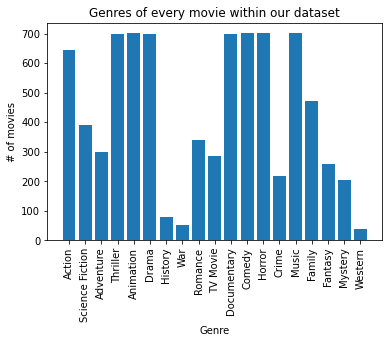

In [7]:
def plotGenre(d):
    data = d.copy()
    
    #read genres from dataframe
    genres = data.columns[7:]
    genreX = []
    genreY = []
    for x in genres:
        genreX.append(x)
        genreY.append(len(data.loc[data[x] == 1]))
    
    #plot genres
    plt.title('Genres of every movie within our dataset')
    plt.xticks(rotation = 90)
    plt.bar(x = genreX, height = genreY)
    plt.xlabel('Genre')
    plt.ylabel('# of movies')
    plt.savefig('charts/genre.png',bbox_inches='tight')
plotGenre(mov_df)

Plot of all release dates within our dataset. <br/>
Although we randomly collected the movie data, with this graph we can see that more and more films have been releasing each year. 

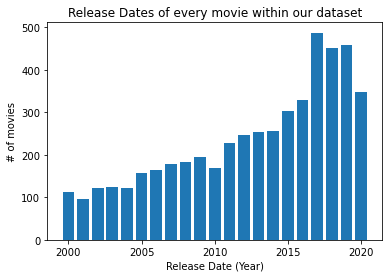

In [8]:
def plotDate(d):
    data = d.copy()
    
    #read dates from dataframe
    dateX = [*range(2000,2021,1)]
    dateY = []
    for x in dateX:
        count = 0
        for y in data['Release_Date']:
            if str(x) == y[0:4]:
                count += 1
        dateY.append(count)
        
    #plot date
    plt.title('Release Dates of every movie within our dataset')
    plt.bar(x = dateX, height = dateY)
    plt.xlabel('Release Date (Year)')
    plt.ylabel('# of movies')
    plt.savefig('charts/dates.png',bbox_inches='tight') 
plotDate(mov_df)

# Part 2 - Exploratory Data Analysis

### Part 2.1 - Dominant Color Extraction
We decided to take a look at the Dominant Colors of each poster in every movie genre since this may be a key factor in deciding the genre of the movie based off of the poster. First we evaluated the dominant color of every movie based on a single genre, but then we paired genres and analyzed that as well.

Dominant colors are extracted using the ColorThief tool. It essentially gets the rgb value array of the image and performs kmeans clustering to get the most dominant color. Originally we created our own, but the model we created was slower than the tool used.

Warning: We don't recommend running the code for this part of the analysis since it may take from 30 min to an hour depending on your computer to extract the colors from all 5000 movies. The results for this analysis are already displayed.

First get dominant colors from every poster and store it inside of the dataframe

In [22]:
domcol = []
for x in res_arr:
    #get dominant colors and palette
    color_thief = ColorThief(x)
    dominant_color = color_thief.get_color(quality=1)
    domcol.append(dominant_color)
mov_df['dominant_color'] = domcol

KeyboardInterrupt: 

In [ ]:
for x in res_arr:
    print(x)

Ready average dominant color for single genres to be graphed

In [ ]:
gen_col = []
yarr = []
for x in mov_df.columns[7:-2]:
    temp = mov_df.loc[mov_df[x] == 1]
    arr = temp['dominant_color'].to_numpy()
    yarr.append(len(arr))
    rgb = []
    rsum = 0
    gsum = 0
    bsum = 0
    for y in arr:
        rsum += y[0]
        gsum += y[1]
        bsum += y[2]
    rsum = rsum / len(arr)
    gsum = gsum / len(arr)
    bsum = bsum / len(arr)
    rgb.append(rsum /255)
    rgb.append(gsum /255)
    rgb.append(bsum /255)
    gen_col.append(rgb)

#### Graph of Dominant Color for single genres. 
The average dominant color of each genre is a brown color with lighter shades in some genres. This may mean that there is little overall relation between dominant color and genre because they converge to a brown color when mixed together and averaged. 

In [ ]:
fig = plt.subplots(figsize = (10,4))
xarr = mov_df.columns[7:-2]

plt.bar(xarr,yarr,color=gen_col)
plt.xlabel('Movie Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.title('Average Dominant Color of each Genre')
plt.savefig('charts/dom_color.png',bbox_inches='tight')

Ready average dominant colors for paired genres since each movie may have more than one genre describing it.

In [12]:
g_arr = mov_df.columns[7:-2].to_numpy()
Xmulti = []
Cmulti = []
Ymulti = []
for x in mov_df.columns[7:-2]:
    for y in g_arr:
        if (x != y) & len(mov_df.loc[(mov_df[x] == 1) & (mov_df[y] == 1)]) > 0 :
            temp = mov_df.loc[(mov_df[x] == 1) & (mov_df[y] == 1)]
            Xmulti.append(x + ', ' + y)
            
            arr = temp['dominant_color'].to_numpy()
            rgb = []
            rsum = 0
            gsum = 0
            bsum = 0
            for y in arr:
                rsum += y[0]
                gsum += y[1]
                bsum += y[2]
            rsum = rsum / len(arr)
            gsum = gsum / len(arr)
            bsum = bsum / len(arr)
            rgb.append(rsum /255)
            rgb.append(gsum /255)
            rgb.append(bsum /255)
            Cmulti.append(rgb)
            Ymulti.append(len(temp))
    g_arr = np.delete(g_arr,0)

#### Graph of average dominant color for paired genres 
There can be multiple genres for each movie. So in this section we explore the paired genres and the average dominant color that can be seen. The only significant changes that deviate from primarily brown are in genres of movies that are less than 20. This is probably because the sample size is too small for movies less than that number and is more easily thrown off. Otherwise the average dominant color is either a brownish color or a greyish color which means dominant color is not as relevant as we thought when looking at the true movie genre labels.

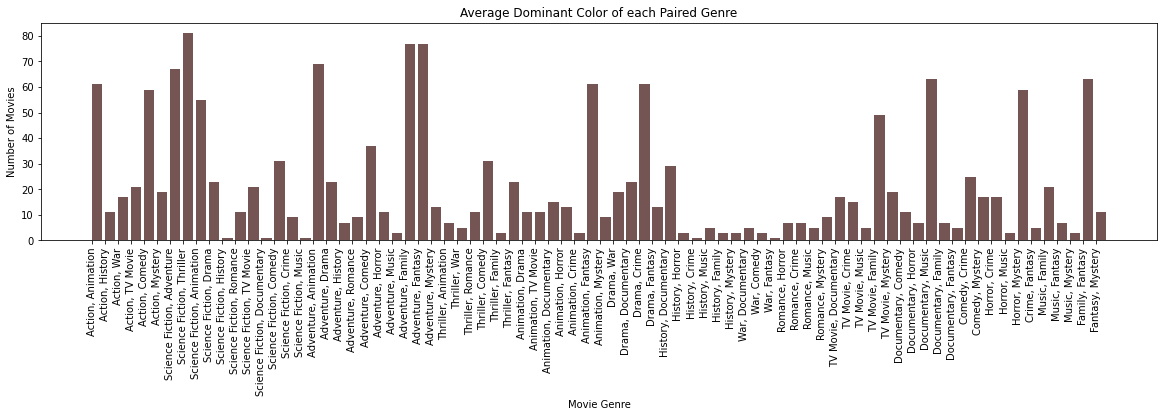

In [13]:
fig = plt.subplots(figsize = (20,4))

plt.bar(Xmulti,Ymulti,color=Cmulti, align = 'edge')
plt.xlabel('Movie Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.title('Average Dominant Color of each Paired Genre')
plt.savefig('dom_color.png',bbox_inches='tight')

### Part 2.2 - Facial Recognition

### Part 2.3 - Convolutional Neural Network

This prediction of genres of a movie based off of other movie posters is a multi-label classification problem. We are trying to assign multiple labels to a poster rather than just one label. Neural networks can be configured to support multi-label classification and can predict well. This is why we have chosen a neural network to make our prediction model. Every node in the neural network uses sigmoid activation and the neural network is fit with the binary cross entropy loss function. More information about the sequential model and its applications can be found here: https://keras.io/guides/sequential_model/

This function sets up the neural network, and creates a sequential prediction model. The model is trained on the processed images above. A summary of the model and its layers is then printed along with plots showing the accuracy of the model evaluated against test data generated by the test_train_split function from sklearn. Finally, the setUpNeuralNetwork function returns the trained model.

In [14]:
def setupNeuralNetwork(dataModel, img_array):
    X_train, X_test, y_train, y_test = train_test_split(img_array, dataModel, random_state = 0, test_size = 0.15)
    #print(X_train.shape)

    #Build sequential CNN
    model = Sequential()

    #Configure convolutional layers, specify filter and activation function
    model.add(Conv2D(16, (3,3), activation='relu', input_shape = X_train[0].shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.3))

    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(len(mov_df.columns) - 7, activation='sigmoid'))
    print(model.summary())
    #print("train:", X_train.shape)
    #print("test:", X_test.shape)

    # Compile and fit the model. Validation data is the data used to evaluate the accuracy of our model
    model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
    #Epochs is the number of times we want to pass the training data through the network.
    history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
    plot_learningCurve(history, 5)
    return model


def plot_learningCurve(history, epoch):
    # Plot training & validation accuracy values
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

The predictGenre function uses the prediction model to predict the genres of the movie given as the input. predict() returns the probabilities for each genre of the movie poster belonging to that genre. The predictGenre function then prints out the 3 genres with the highest probability values.

In [15]:
def predictGenre(model, img):
    img = image.load_img(img, target_size = (img_width, img_height, 3))
    plt.imshow(img)
    img = image.img_to_array(img)
    img = img/255.0
    img = img.reshape(1, img_width, img_height, 3)

    genres = data.columns[7:]
    #print(genres)
    probGenres = model.predict(img)
    #print(probGenres[0])
    #print(np.argsort(probGenres[0]))
    top3Genres = np.argsort(probGenres[0])[:-4:-1]
    #print(probGenres[0][top3Genres])
    print("Genres: ")
    for i in range(3):
            print(genres[top3Genres[i]])

Warning: We don't recommend running the next block of code since it may take hours depending on your computer to create a model from scratch. The trained model has already been saved in a folder and can be loaded to make our predictions. It's summary has also been printed above.

In [16]:
model = setupNeuralNetwork(dataModel, img_array)
model.save("savedModel")
print("Model has been saved")

NameError: name 'train_test_split' is not defined



Since the validation accuracy is greater than training accuracy and validation loss is less than the training loss, we know that the model isn't overfitting the data. It is quite accurate when it comes to predicting the genres of images as we can see from the graphs. The model has been saved to a folder named "savedModel". This can be loaded later on to make our predictions.


# Part 3 - Final Analysis

### Conclusions
Looking at the results from the dominant color analysis of the movie posters (2.1), we see that each genre's movie posters have almost the same color composition. Since there isn't any conclusive evidence that color composition of a movie poster determines its genre, we will disregard it as a factor in our prediction model.

We wanted to do more with emotion detection, but our choices in APIs that handled this was limited. If we wanted to figure out more related to emotion, we would have to train our own model which is unrelated to the movie itself. [Fill this out with results from the face detection analysis]

Our sequential model does a pretty good job of predicting genres from movie posters. We can test it out by running the predictGenre function on some movie posters -


In [ ]:
# Loading the saved model
loaded_model = load_model("savedModel")
# Using predictGenre function on the 'us' movie poster
predictGenre(loaded_model, "us.jpg")

In [ ]:
predictGenre(loaded_model, "beatles.png")

As we can see, the neural network could be used to predict genres of movies from their movie posters. However, it isn't always correct. Problems for all exploration tools occur because most movies belong to multiple genres. In addition, movie poster creators may not always do a good job at conveying genres through the images. Despite the model's limitations, our movie poster prediction model would be of great use to entertainment providers in choosing which posters to use for movies to attract audiences of different genres.